In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Functions

In [2]:
def make_vote_df_from_proposal_id(proposal_id):
    url = 'https://hub.snapshot.org/graphql/'
    vote_query = create_vote_query(proposal_id)
    vote_response = requests.post(url, json={'query': vote_query})
    print(proposal_response.status_code,proposal_response.reason,proposal_id)
    vote_json = vote_response.json()
    vote_df = vote_json_to_df(vote_json)
    return vote_df
    
def create_vote_query(proposal_id):
    vote_query = '''
    query Votes {
      votes (
        first: 9999999
        skip: 0
        where: {
          proposal: "'''+ proposal_id + '''"
        }
        orderBy: "created",
        orderDirection: desc
      ) {
        id
        ipfs
        voter
        created
        space {
          id
        }
        proposal {
          id
        }
        choice
        metadata
        vp
        vp_by_strategy
        vp_state
      }
    }
    '''
    return vote_query
def vote_json_to_df(vote_json):
    row_as_series_list=[]
    for vote in vote_json['data']['votes']:
        id = vote['id']
        ipfs = vote['ipfs']
        voter = vote['voter']
        created = vote['created']
        space = vote['space']['id']
        proposal = vote['proposal']['id']
        choice = vote['choice']
        #metadata = vote['metadata']: {},
        vp = vote['vp']
        vp_by_strategy = tuple(vote['vp_by_strategy'])
        vp_state = vote['vp_state']
        row_as_series  = pd.Series(
            data=(
                id,
                ipfs,
                voter,
                created,
                space,
                proposal,
                choice,
                #metadata,
                vp,
                vp_by_strategy,
                vp_state,
                ),
            index=(
                'vote_id',
                'ipfs',
                'voter',
                'created',
                'space',
                'proposal',
                'choice',
                #'metadata',
                'vp',
                'vp_by_strategy',
                'vp_state',
            )
        )
        row_as_series_list.append(row_as_series)
    return_df = pd.DataFrame(row_as_series_list)
    return return_df


# Querying and Dumping the Data

In [3]:
proposal_query = '''
query Proposals {
  proposals (
    first: 10000000
    where: {
      space_in: ["index-coop.eth"],
      state: "closed"
    },
    orderBy: "created",
    orderDirection: desc
  ) {
    id
    title
    body
    choices
    start
    end
    snapshot
    state
    author
    scores
    scores_by_strategy
    scores_state
    scores_total
    scores_updated
    created
    votes
    space {
      id
      name
    }
  }
}
'''
#print(proposal_query)

In [4]:
url = 'https://hub.snapshot.org/graphql/'
proposal_response = requests.post(url, json={'query': proposal_query})
print(proposal_response.status_code,proposal_response.reason)

200 OK


In [5]:
proposal_json = proposal_response.json()

In [6]:
#proposal_json

In [7]:
#proposal_json

In [8]:
# Dump Proposal Dataframe
proposal_row_list = []
for proposal in proposal_json['data']['proposals']:
    id = proposal['id']
    title = proposal['title']
    body = proposal['body']
    choices = tuple(proposal['choices'])
    scores = tuple(proposal['scores'])
    scores_total = proposal['scores_total']
    votes = proposal['votes']
    created = proposal['created']
    
    proposal_row = pd.Series(data=[id,created, title,body,choices,scores,scores_total,votes],
                      index = ['proposal_id','created','title','body','choices','scores','scores_total','votes']
                     )
    proposal_row_list.append(proposal_row)

proposals_df = pd.DataFrame(proposal_row_list)



## Cleaning Proposal df

In [9]:
def make_proposal_category(title):
    '''
    Logic for parsing the title to categorize the proposal.
    '''
    if ('DG1' in title or 'Decision Gate 1' in title):
        category = 'DG1'
    elif ('DG2' in title or 'Decision Gate 2' in title): 
        category = 'DG2'
    elif ('IIP' in title): 
        category = 'IIP'
    else: 
        category = 'Metagovernance'
    return category
def make_proposal_result(row):
    '''
    Logic for checking if the proposal passed or not. 
    1 is FOR
    2 is AGAINST
    '''
    category = row['category']
    percentage_for = row['percentage_for']
    #print(category)
    #print(percentage_for)
    #print(type(percentage_for))
    if category == 'DG2':
        if percentage_for >.6:
            return 1 
        else:
            return 2
    else:
        if percentage_for >.5:
            return 1
        else:
            return 2
    

In [10]:
proposals_df['created'] = pd.to_datetime(proposals_df['created'],unit='s')
proposals_df['category'] = proposals_df['title'].apply(make_proposal_category) # Make category column
proposals_df = proposals_df[proposals_df['choices'].apply(len) == 2] # Remove multi-choice proposals
proposals_df = proposals_df[proposals_df['scores_total'] !=0] # Remove dummy proposals
proposals_df['reached_quorum'] = proposals_df['scores_total'] > 100000 # 100k is a placeholder value for quorum 
proposals_df['percentage_for'] = proposals_df['scores'].map(lambda x: x[0])/proposals_df['scores_total']
proposals_df['result'] = proposals_df.apply(make_proposal_result,axis=1) # Make category column
proposals_df.to_json('proposals_df.json')

In [11]:
proposals_df

,proposal_id,created,title,body,choices,scores,scores_total,votes,category,reached_quorum,percentage_for,result
0,QmceW9t1BpsuvJYue8VsR7hodte6L95rUV2pGSZALJX2vb,2021-11-30 23:18:26,"[COMPOUND-72] Risk Parameter Updates for WBTC,...",This proposal is for voting on Compound's prop...,"(For, Against)","(24980.931571880352, 0)",24980.931572,49,Metagovernance,False,1.000000,1
1,Qmf9zQAiL1eJwDhy7SPXhNjSNhga3xnHrxLp373amCGnzV,2021-11-30 17:31:32,[AAVE-50] Q2 Dynamic Risk Parameters,This proposal is for voting on Aave's proposal...,"(For, Against)","(287762.3443888976, 0)",287762.344389,36,Metagovernance,True,1.000000,1
2,0xc6b656f97240505912508f6a47ca0bf117732833da22...,2021-11-29 16:30:42,IIP-113: Index Coop Product Launch & Maintenan...,"Status: Proposed\nAuthor(s): @cavalier_eth, @d...","(FOR, AGAINST)","(109994.5318624229, 470487.62399540434)",580482.155858,95,IIP,True,0.189488,2
3,0x44ba0f55de0c4d6875b36f3f7cdacb3b144bd782d953...,2021-11-29 13:39:50,"IIP-116: Redirect DPI, MVI, DATA and BED Reven...",Status: Proposed\nAuthor: @Finance.Nest @Matt...,"(FOR, AGAINST)","(298193.7761800109, 0)",298193.776180,67,IIP,True,1.000000,1
4,0x1aa4fdb6f42d866c7ba5f80ceea61358051039df7a22...,2021-11-29 13:23:46,IIP-115: Authorize the Investment Account for ...,Status: Proposed\nAuthor: @Finance.Nest\nCreat...,"(FOR, AGAINST)","(112551.43231509204, 1181.6703018834307)",113733.102617,64,IIP,True,0.989610,1
...,...,...,...,...,...,...,...,...,...,...,...,...
201,QmSSZzLPbLpegBWfxPBTVAdvUZoXAL2V6Hi58YHEi6bemW,2020-12-16 02:13:40,IIP-7 CoinShares Gold and Cryptoassets Index L...,## Simple Summary\n\nThe CoinShares Gold and C...,"(FOR, AGAINST)","(207237.6314297594, 136489.5390568919)",343727.170487,93,IIP,True,0.602913,1
202,QmethJXKnCMd89wWBaxCBRcK2Hu8Dhx5E5AM7XeHEKsL1n,2020-12-11 21:20:11,[COMPOUND-32] Distribute COMP to Affected User...,This proposal is for voting on Compound's prop...,"(For, Against)","(67189.52469698468, 108859.87904773426)",176049.403745,77,Metagovernance,True,0.381652,2
203,QmTdYHoyT5eLWSZduHkivVxs3Vree1EUQUYCk8uoW4Q1EA,2020-12-07 21:50:10,[COMPOUND-31] Adjusting Reserve Factors,This proposal is for voting on Compound's prop...,"(For, Against)","(108963.72591013898, 0.01090957898367475)",108963.736820,45,Metagovernance,True,1.000000,1
204,QmRw6FoXJRhm4WLaWVuRgsXhE7ZfWvAKY42E386ksugfUC,2020-12-06 06:10:07,[COMPOUND-30] COMP Contributor Grants,This proposal is for voting on Compound's prop...,"(For, Against)","(138478.01939721234, 85.89796163862161)",138563.917359,82,Metagovernance,True,0.999380,1


### Double check that the choices are in the correct order

In [12]:
proposals_df['choices'].value_counts()

(FOR, AGAINST)                                                         102
(For, Against)                                                          86
(Approve, Reject)                                                        4
(FOR , AGAINST)                                                          2
(Yes, No)                                                                1
(Fund Balancer Grants DAO Wave 2, Do not fund)                           1
(Stop BAL for Gas, Continue BAL for Gas)                                 1
(Approve, Deny)                                                          1
(Proceed with "Whale" Sponsorship, Do not proceed with sponsorship)      1
(Approve Grant, Deny Grant)                                              1
(Yes, I support this proposal, No, I am against this proposal)           1
(yes, I vote for this proposal, no, I vote against this proposal)        1
(Yes we would love a Telegram, Discord is enough)                        1
(FOR, AGAINST )          

When we did this, we wanted the first choice to always be "yes"

In [13]:
#

In [14]:
# Dump Vote Dataframe
votes_df_list = []
for proposal in proposal_json['data']['proposals']:
    #print(proposal['state'],proposal['choices'])
    if proposal['state'] != 'closed':
        continue
    else:
        votes_for_proposals_df = make_vote_df_from_proposal_id(proposal['id'])
        votes_df_list.append(votes_for_proposals_df)
        
all_votes_df = pd.concat(votes_df_list,ignore_index=True)
all_votes_df['created'] = pd.to_datetime(all_votes_df['created'],unit='s') #Convert to datetime


200 OK QmceW9t1BpsuvJYue8VsR7hodte6L95rUV2pGSZALJX2vb
200 OK Qmf9zQAiL1eJwDhy7SPXhNjSNhga3xnHrxLp373amCGnzV
200 OK 0xc6b656f97240505912508f6a47ca0bf117732833da22817252d3c1c7100fcd69
200 OK 0x44ba0f55de0c4d6875b36f3f7cdacb3b144bd782d9535c52862cd8c41fd1848f
200 OK 0x1aa4fdb6f42d866c7ba5f80ceea61358051039df7a22385a29c8401c1146f7cf
200 OK 0xba1e51dcaa304833ec3307b0c95fdf525443cfe477d682c735206bdf6ebe5a62
200 OK 0xd031343b706075a757650903fc1d3f5e9676f6eff682cc6b1c5692a1607b763f
200 OK 0x4dee2def2333c40a5fdbe244cc0e641f099acb44edccc9ba8101dfbf37555353
200 OK 0xbecffc979a7e3c1d98844a239987ceeeaa8f0c43d49fc8995e7905371636675b
200 OK 0x0b70d0cdd97874eca00769fe1c323351a3e7c473bff876b2662e8d3e0a1e75bb
200 OK 0xab2226aff5ab574d15e357c0815e65a89b817dc741bb5bfa1a4d48802010c984
200 OK 0x81ba2833504ea67c0d82e923a500afb54aa62ca74eeded97be6050d947a47e8e
200 OK QmaGZeBayJGQpFZWYSxrKndyf65ukyeTd9bFqjpDcbWMHG
200 OK QmPmuC4JZKy4kYqA7eBGHAgzpQUQNyGCb3wRZUudBKP3GN
200 OK QmTsi5WNdBknEBKEjXnzR5PRGRtv9FFLRYyoo

## Cleaning Vote Dataframe

In [15]:
def remove_zero_vp_proposals(all_votes_df):
    vp_sum_df = all_votes_df.groupby('proposal')['vp'].sum() 
    zero_vp_proposals = vp_sum_df[vp_sum_df==0].index
    all_votes_df = all_votes_df[~all_votes_df['proposal'].isin(zero_vp_proposals)]
    return all_votes_df

In [16]:
all_votes_df = remove_zero_vp_proposals(all_votes_df) 
all_votes_df.to_json('all_votes_df.json')

# Analysis

###  What percentage of proposals are unanimous?


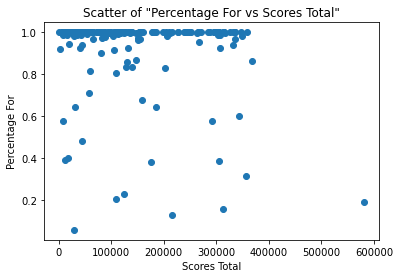

In [17]:
# What percentage of proposals are unanimous?
proposals_df['percentage_for'] = proposals_df['scores'].map(lambda x: x[0])/proposals_df['scores_total']
plt.scatter(proposals_df['scores_total'],proposals_df['percentage_for'])
plt.xlabel('Scores Total')
plt.ylabel('Percentage For')
plt.title('Scatter of "Percentage For vs Scores Total"')
plt.show()

# King Maker / Deciding Vote

In [18]:
def winning_threshold(choice,category):
    if category == 'DG2':
        if choice == 1:
            return .6
        else:
            return .4
    else:
        return .5
    
def is_deciding_vote(row):
    '''
    Assuming that a vote is ALREADY on the winning side,
    A vote is a considered a deciding vote if the following statement holds:
    'If the vote had switched sides, then it would have still been on the winning side.'
    '''
    vp = row['vp']
    choice = row['choice']
    category = row['category']
    scores_total = row['scores_total']
    coalition_vp = row['coalition_vp']
    reached_quorum = row['reached_quorum']
    
    if not reached_quorum:
        return "no quorum"
    else:
        #old_choice = choice
        #old_my_team_score= coalition_vp
        #old_enemy_team_score = scores_total-coalition_vp

        new_choice = (choice) % 2 + 1 # 1 goes to 2, 2 goes to 1
        new_coalition_vp = scores_total-(coalition_vp-vp)


        new_percentage = new_coalition_vp/scores_total

        new_wins = new_percentage > winning_threshold(new_choice,category)

        return str(new_wins)

In [19]:
#Merge
merged_df = pd.merge(all_votes_df,proposals_df,left_on='proposal',right_on='proposal_id',how='inner')

In [20]:
#Create columns
merged_df['coalition_vp'] = merged_df.apply(lambda row: row.scores[row.choice-1],axis=1)
merged_df['coalition_contribution'] = merged_df['vp']/merged_df['coalition_vp']
merged_df['is_winning_coalition'] = merged_df['choice']==merged_df['result']

In [21]:
#Filter and create deciding_vote column
winning_coalition_df = merged_df[merged_df['is_winning_coalition']]
winning_coalition_df['is_deciding_vote'] = winning_coalition_df.apply(is_deciding_vote,axis=1)


<ipython-input-21-70ee56d1b163>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_coalition_df['is_deciding_vote'] = winning_coalition_df.apply(is_deciding_vote,axis=1)


In [22]:
#Pivot
deciding_vote_df = winning_coalition_df.sort_values(by='coalition_contribution',ascending=False).groupby(['voter','is_deciding_vote']).size()\
                       .reset_index(name='counts')\
                       .pivot_table(index='voter',columns='is_deciding_vote',values='counts',fill_value=0)\
                       .sort_values(by='True',ascending=False)

In [23]:
voter_by_vp_df = winning_coalition_df.groupby('voter').agg(mean_vp=('vp', 'mean'),
                                                           min_vp=('vp', 'min'),
                                                           max_vp=('vp', 'max'),
                                                          )
#voter_by_vp_df

In [24]:
merged_deciding_vote_df = deciding_vote_df.merge(voter_by_vp_df,on='voter',how='inner')

### Deciding voters and how much VP they have

In [25]:
merged_deciding_vote_df.round(0).head(20)

,False,True,no quorum,mean_vp,min_vp,max_vp
voter,,,,,,
0x8627be8D8b6D250c87f802D0c48C26FA807A0857,0,33,0,187922.0,187922.0,187922.0
0x4a3e950c35c6d9c2d8f5F0a6CC03aF9942134840,12,8,0,71242.0,44093.0,80640.0
0x365047213ABe97401e8Bfa2c48D12d2731601F98,0,6,0,196330.0,123949.0,235515.0
0x4EC7CdF61405758f5cED5E454c0B4b0F4F043DF0,10,3,0,68307.0,66832.0,68569.0
0xcfc50541c3dEaf725ce738EF87Ace2Ad778Ba0C5,7,2,0,50476.0,48639.0,52790.0
0xaAa604E8f5318373D1785766D4f7310AF6CC4891,29,1,10,24018.0,22950.0,24768.0
0xb647055A9915bF9c8021a684E175A353525b9890,2,1,0,100000.0,100000.0,100000.0
0x9fB64b232dEa3ba6e020F517b2BC8aFd0145880c,0,1,0,41225.0,41225.0,41225.0
0xB933AEe47C438f22DE0747D57fc239FE37878Dd1,8,1,0,31187.0,29522.0,31395.0


In [26]:
def sum_true(grp):
    return np.sum(grp=='True')
def create_has_deciding_vote(row):
    if row['reached_quorum'] == False:
        return 'no quorum'
    else:
        return str(row['num_deciding_votes']>0)

In [27]:
deciding_votes_by_proposal_df = winning_coalition_df.groupby(['proposal','category','votes','reached_quorum'])\
    .agg(num_deciding_votes=('is_deciding_vote',sum_true)).reset_index()
                       
deciding_votes_by_proposal_df['has_deciding_vote'] = deciding_votes_by_proposal_df.apply(create_has_deciding_vote,axis=1) 

 Note, there are two proposals with more than 1 deciding vote

### Number of deciding votes by Proposal

In [28]:
deciding_votes_by_proposal_df

,proposal,category,votes,reached_quorum,num_deciding_votes,has_deciding_vote
0,0x0b70d0cdd97874eca00769fe1c323351a3e7c473bff8...,DG2,61,True,1,True
1,0x1aa4fdb6f42d866c7ba5f80ceea61358051039df7a22...,IIP,64,True,0,False
2,0x26ea01b07411488227517a164bdfa5ee5c06792bd976...,IIP,54,True,1,True
3,0x31a11f7f37c0319785cad3ab7353745731c3d33908b5...,DG1,66,True,1,True
4,0x40edf5d2828a0473626a8a7bfa22a8755fb847a95563...,DG1,57,True,1,True
...,...,...,...,...,...,...
199,Qmf9zQAiL1eJwDhy7SPXhNjSNhga3xnHrxLp373amCGnzV,Metagovernance,36,True,1,True
200,QmfEFdo3byE9XsgfZrP2XG7VJwoeYSb3m56oF93hDeDMth,IIP,59,True,0,False
201,QmfGRkXA5gj2ske8Ci45wZnA9BRQg38iQ9vkpegABi9EbW,IIP,85,True,0,False
202,QmfMqLAiJmgjTpNaXyVFkZtCaV2kBDtzp4dMhzdvzQCrKZ,Metagovernance,20,True,1,True


In [29]:
deciding_votes_by_proposal_df.groupby(['category','has_deciding_vote']).size()\
.reset_index(name='counts')\
.pivot_table(index='category',columns='has_deciding_vote',values='counts',fill_value=0)



has_deciding_vote,False,True,no quorum
category,,,
DG1,6,8,5
DG2,5,5,2
IIP,35,30,8
Metagovernance,11,10,79
